# Next Up: Predictive Modeling

## Project Goal
Build a machine learning model to predict which G-League players will be called up to the NBA.

**Target Variable**: `called_up` (binary: 1 = called up, 0 = not called up)

**Dataset**: `data/prediction_dataset_cleaned.csv` - Cleaned dataset with top features (2021 season excluded)

---

## Notebook Structure
1. **Modeling Strategy Discussion** - Plan our approach
2. **Data Loading & Preparation** - Load cleaned data and prepare for modeling
3. **Model Training** - Train multiple models and compare
4. **Model Evaluation** - Evaluate performance with appropriate metrics
5. **Feature Importance Analysis** - Understand what drives predictions
6. **Model Selection & Final Model** - Choose best model and finalize
7. **Predictions & Insights** - Generate predictions and insights

---

## Section 1: Modeling Strategy Discussion

Before building models, let's discuss and decide on our approach for this imbalanced classification problem.


### 1.1 Problem Characteristics

**Problem Type**: Binary Classification (Imbalanced)
- **Target**: `called_up` (1 = called up, 0 = not called up)
- **Class Distribution**: ~8-9% positive class (called up), ~91-92% negative class
- **Data Size**: ~1,900 records (after excluding 2021)
- **Features**: ~30 top features from correlation analysis

**Key Challenges**:
1. **Severe Class Imbalance**: Only ~8-9% of players get called up
2. **Small Dataset**: Limited training data
3. **Temporal Nature**: Data spans multiple seasons (2019, 2022, 2023, 2024)
4. **Feature Quality**: Features are performance statistics that may have multicollinearity


### 1.2 Model Selection Strategy

**Recommended Models to Try**:

1. **Logistic Regression** (Baseline)
   - **Pros**: Interpretable, fast, good baseline, handles multicollinearity with regularization
   - **Cons**: Linear decision boundary, may struggle with complex patterns
   - **Use Case**: Baseline model, feature importance analysis

2. **Random Forest** (Primary Candidate)
   - **Pros**: Handles non-linear relationships, feature importance, robust to outliers, built-in class weights
   - **Cons**: Can overfit with small datasets, less interpretable than logistic regression
   - **Use Case**: Strong candidate for final model

3. **XGBoost** (Primary Candidate)
   - **Pros**: State-of-the-art performance, handles imbalanced data well, feature importance
   - **Cons**: More complex, requires careful tuning, can overfit
   - **Use Case**: Strong candidate if we have enough data

4. **Gradient Boosting** (Alternative)
   - **Pros**: Good performance, handles imbalance
   - **Cons**: Similar to XGBoost but may be slower

**Decision**: Start with Logistic Regression (baseline), then try Random Forest and XGBoost. Choose based on validation performance.


### 1.3 Train/Validation/Test Split Strategy

**Options**:

**Option A: Time-Based Split (RECOMMENDED)**
- **Train**: 2019, 2022 seasons (older data)
- **Validation**: 2023 season (recent data for tuning)
- **Test**: 2024 season (most recent, unseen data)
- **Pros**: Realistic evaluation, prevents data leakage, tests temporal generalization
- **Cons**: Smaller training set, may have distribution shift
- **Rationale**: We want to predict future call-ups, so testing on most recent season is most realistic

**Option B: Random Stratified Split**
- **Train**: 70%, Validation: 15%, Test: 15%
- **Pros**: Larger training set, maintains class distribution
- **Cons**: May have data leakage if same player appears in multiple seasons, less realistic
- **Rationale**: Good for initial exploration but less realistic for deployment

**Option C: Player-Based Split**
- Split by unique players (not player-seasons)
- **Pros**: Prevents same player appearing in train/test
- **Cons**: Complex, may have very small test set
- **Rationale**: Good if we're concerned about player-level leakage

**Decision**: **Use Option B (Random Stratified Split + Hold-Out Test)**
- More flexible for model development and hyperparameter tuning
- Maintains class balance across splits
- Still allows us to keep a true hold-out test set for final evaluation


### 1.4 Evaluation Metrics

**For Imbalanced Classification, we need multiple metrics**:

**Primary Metrics**:

1. **F1-Score** (Primary Metric)
   - Harmonic mean of precision and recall
   - Balances both false positives and false negatives
   - **Why**: We care about both identifying call-ups correctly AND not missing potential call-ups
   - **Target**: > 0.30-0.40 (challenging with 8% positive rate)

2. **Precision** (Positive Predictive Value)
   - Of players we predict as "called up", how many actually got called up?
   - **Why**: Important for resource allocation - don't want to waste attention on false positives
   - **Target**: > 0.40-0.50

3. **Recall** (Sensitivity)
   - Of all players who actually got called up, how many did we identify?
   - **Why**: Important to catch as many real call-ups as possible
   - **Target**: > 0.40-0.60

4. **ROC-AUC** (Area Under ROC Curve)
   - Overall model discrimination ability
   - **Why**: Good for comparing models, less affected by class imbalance
   - **Target**: > 0.70-0.80

5. **Precision-Recall AUC**
   - Better than ROC-AUC for imbalanced data
   - **Why**: Focuses on positive class performance
   - **Target**: > 0.30-0.50

**Secondary Metrics**:

6. **Confusion Matrix** - Visual breakdown of predictions
7. **Classification Report** - Detailed per-class metrics
8. **Feature Importance** - Understand model decisions

**Decision**: Focus on **F1-Score** as primary metric, but report all metrics for comprehensive evaluation.


### 1.5 Handling Class Imbalance

**Strategies to Consider**:

1. **Class Weights** (RECOMMENDED - Start Here)
   - Automatically adjust model to penalize misclassifying minority class more
   - **Implementation**: `class_weight='balanced'` in sklearn models
   - **Pros**: Simple, no data manipulation, works with all models
   - **Cons**: May not be enough for severe imbalance

2. **SMOTE (Synthetic Minority Oversampling)**
   - Generate synthetic examples of minority class
   - **Pros**: Increases training data, can improve recall
   - **Cons**: May create unrealistic examples, can overfit
   - **Use Case**: If class weights aren't sufficient

3. **Undersampling Majority Class**
   - Randomly remove negative examples
   - **Pros**: Faster training, balanced classes
   - **Cons**: Loses information, may hurt performance
   - **Use Case**: Not recommended with small dataset

4. **Cost-Sensitive Learning**
   - Assign higher cost to misclassifying positive class
   - **Pros**: Flexible, can tune cost ratio
   - **Cons**: Requires tuning cost parameter

**Decision**: **Start with Class Weights** for all models. If performance is poor, try SMOTE as a second approach.


### 1.6 Feature Engineering & Preprocessing

**Preprocessing Steps**:

1. **Feature Scaling**
   - **StandardScaler** for Logistic Regression (required)
   - **Not needed** for tree-based models (Random Forest, XGBoost)
   - **Decision**: Scale features for Logistic Regression only

2. **Feature Selection**
   - Already done in EDA - using top 30 features
   - May further reduce if multicollinearity is high
   - **Decision**: Start with top 30 features, reduce if needed

3. **Categorical Encoding**
   - Position: One-hot encode or label encode
   - **Decision**: One-hot encode position (if we include it)

4. **Handling Multicollinearity**
   - Many features are correlated (e.g., total_points vs points)
   - **Decision**: Monitor but don't remove yet - let models handle it (regularization, feature importance)

**Decision**: Minimal preprocessing - scale for Logistic Regression, use raw features for tree models.


### 1.7 Hyperparameter Tuning Strategy

**Approach**: Use validation set for hyperparameter tuning

**Models to Tune**:

1. **Logistic Regression**
   - `C` (regularization strength): [0.01, 0.1, 1, 10, 100]
   - `penalty`: ['l1', 'l2', 'elasticnet']
   - `solver`: ['liblinear', 'saga']

2. **Random Forest**
   - `n_estimators`: [100, 200, 300]
   - `max_depth`: [5, 10, 15, None]
   - `min_samples_split`: [2, 5, 10]
   - `min_samples_leaf`: [1, 2, 4]
   - `class_weight`: ['balanced', 'balanced_subsample']

3. **XGBoost**
   - `n_estimators`: [100, 200, 300]
   - `max_depth`: [3, 5, 7]
   - `learning_rate`: [0.01, 0.1, 0.2]
   - `scale_pos_weight`: [auto, manual tuning for class imbalance]

**Tuning Method**: GridSearchCV or RandomizedSearchCV on validation set
- Use **RandomizedSearchCV** for faster exploration
- Use **GridSearchCV** for final fine-tuning of best model

**Decision**: Use RandomizedSearchCV for initial exploration, then fine-tune best model with GridSearchCV.


### 1.8 Model Selection Criteria

**Final Model Selection**:

We'll compare models based on:
1. **Primary**: F1-Score on validation set
2. **Secondary**: 
   - Precision (don't want too many false positives)
   - Recall (want to catch real call-ups)
   - ROC-AUC (overall discrimination)
3. **Practical Considerations**:
   - Interpretability (feature importance)
   - Training time
   - Prediction speed

**Decision Process**:
1. Train all models with default/class weights
2. Compare validation performance
3. Tune hyperparameters for top 2-3 models
4. Select best model based on validation F1-score
5. Evaluate final model on test set (only once!)

**Important**: Test set is only evaluated once on the final selected model to avoid overfitting.


### 1.9 Summary of Decisions

| Aspect | Decision | Rationale |
|--------|---------|-----------|
| **Models** | Logistic Regression, Random Forest, XGBoost | Baseline + two strong candidates |
| **Split Strategy** | Random stratified split: Train/Val/Test with hold-out test set | More flexible for tuning; still realistic with a held-out test |
| **Primary Metric** | F1-Score | Balances precision and recall |
| **Class Imbalance** | Class weights (start), SMOTE (if needed) | Simple and effective |
| **Feature Scaling** | Yes for Logistic Regression, No for tree models | Tree models don't need scaling |
| **Hyperparameter Tuning** | RandomizedSearchCV → GridSearchCV | Efficient exploration then fine-tuning |
| **Model Selection** | Best F1-score on validation set | Primary metric for comparison |

**Next Steps**: 
1. Load and prepare data
2. Implement time-based split
3. Train baseline models
4. Evaluate and compare
5. Tune best models
6. Select final model
7. Evaluate on test set


---

## Section 2: Data Loading & Preparation

Now let's load the cleaned dataset and prepare it for modeling according to our strategy.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score, 
                             average_precision_score)
import xgboost as xgb
import joblib

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


In [2]:
# Load cleaned dataset
df = pd.read_csv('data/prediction_dataset_cleaned.csv')

print(f"✅ Dataset loaded successfully")
print(f"   Shape: {df.shape}")
print(f"   Columns: {len(df.columns)}")
print(f"\nFirst few rows:")
df.head()


✅ Dataset loaded successfully
   Shape: (1932, 34)
   Columns: 34

First few rows:


,avg_efficiency,total_efficiency,total_games_started,total_two_points_made,total_field_goals_made,fgm,avg_field_goals_made,total_points,points,total_two_points_att,avg_points,total_field_goals_at_rim_made,total_defensive_rebounds,total_free_throws_made,ftm,total_true_shooting_att,total_free_throws_att,fta,avg_two_points_made,fga,total_field_goals_att,avg_two_points_att,avg_def_rebounds,avg_minutes,avg_true_shooting_att,avg_field_goals_att,total_field_goals_at_rim_att,avg_rebounds,total_rebounds,rebounds,called_up,player_name,season_year,position
0,17.56,158,9,41,63,63,7.00,155,155,76,17.2,18,58,4,4,143.40,10,10,4.56,139,139,8.44,6.44,34.2,15.93,15.44,24,7.67,69,69,0,Ousmane Dieng,2022,F
1,0.25,1,0,1,1,1,0.25,2,2,3,0.5,0,2,0,0,9.00,0,0,0.25,9,9,0.75,0.50,8.3,2.25,2.25,0,0.75,3,3,0,Kevin Kangu,2022,G
2,0.00,0,0,0,0,0,0.00,0,0,0,0.0,0,0,0,0,0.00,0,0,0.00,0,0,0.00,0.00,0.0,0.00,0.00,0,0.00,0,0,0,Quade Green,2022,G
3,11.39,205,10,52,59,59,3.28,137,137,85,7.6,40,61,7,7,118.28,12,12,2.89,113,113,4.72,3.39,18.5,6.57,6.28,49,5.33,96,96,0,Sacha Killeya-Jones,2022,C
4,14.67,176,1,61,65,65,5.42,169,169,120,14.1,38,41,21,21,141.32,28,28,5.08,129,129,10.00,3.42,25.9,11.78,10.75,56,4.33,52,52,0,Scotty Hopson,2022,G-F


In [3]:
# Check data quality
print("Dataset Info:")
print(f"  - Total records: {len(df):,}")
print(f"  - Missing values: {df.isnull().sum().sum()}")
print(f"  - Target distribution:")
print(df['called_up'].value_counts())
print(f"\n  - Call-up rate: {df['called_up'].mean()*100:.2f}%")

# Check season distribution
if 'season_year' in df.columns:
    print(f"\nSeason distribution:")
    print(df['season_year'].value_counts().sort_index())


Dataset Info:
  - Total records: 1,932
  - Missing values: 0
  - Target distribution:
called_up
0    1818
1     114
Name: count, dtype: int64

  - Call-up rate: 5.90%

Season distribution:
season_year
2019    450
2022    450
2023    506
2024    526
Name: count, dtype: int64


---

## Section 3: Data Splitting (Stratified Random + Hold-Out Test)

Randomly split the dataset into train/validation/test sets using stratified sampling to preserve the class imbalance structure.

- **Train**: 60% of data (used for model fitting + k-fold CV during tuning)
- **Validation**: 20% of data (used for baseline comparison and sanity checks)
- **Test**: 20% of data (held out for final evaluation only)


In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# Define feature columns (exclude identifiers and target)
exclude_cols = ['player_name', 'season_year', 'called_up']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Identify categorical and numeric features
categorical_cols = ['position'] if 'position' in feature_cols else []
numeric_cols = [col for col in feature_cols if col not in categorical_cols]

print("Feature Preparation:")
print(f"  - Total features: {len(feature_cols)}")
print(f"  - Numeric features: {len(numeric_cols)}")
print(f"  - Categorical features: {len(categorical_cols)}")
if categorical_cols:
    print(f"  - Categorical: {categorical_cols}")

# Separate features and target
X = df[feature_cols].copy()
y = df['called_up'].copy()

# First split: Train+Val vs Test (20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Second split: Train vs Validation (from remaining 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 25% of 80% = 20% of total
    stratify=y_temp,
    random_state=42
)

print("Stratified Random Data Split:")
print("=" * 60)
print(f"Train Set:")
print(f"  - Records: {len(X_train):,}")
print(f"  - Called up: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"  - Not called up: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")

print(f"\nValidation Set:")
print(f"  - Records: {len(X_val):,}")
print(f"  - Called up: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"  - Not called up: {(y_val == 0).sum():,} ({(y_val == 0).mean()*100:.2f}%)")

print(f"\nTest Set:")
print(f"  - Records: {len(X_test):,}")
print(f"  - Called up: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"  - Not called up: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")

print(f"\nTotal: {len(X):,} records")

# Set up Stratified K-Fold for hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n✅ StratifiedKFold (5-fold) set up for hyperparameter tuning")


Feature Preparation:
  - Total features: 31
  - Numeric features: 30
  - Categorical features: 1
  - Categorical: ['position']
Stratified Random Data Split:
Train Set:
  - Records: 1,158
  - Called up: 68 (5.87%)
  - Not called up: 1,090 (94.13%)

Validation Set:
  - Records: 387
  - Called up: 23 (5.94%)
  - Not called up: 364 (94.06%)

Test Set:
  - Records: 387
  - Called up: 23 (5.94%)
  - Not called up: 364 (94.06%)

Total: 1,932 records

✅ StratifiedKFold (5-fold) set up for hyperparameter tuning


In [5]:
# (Deprecated) Feature prep previously done here for time-based split.
# All feature preparation and splits are now handled in the previous cell.

print(f"\n✅ Data prepared for modeling")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_val shape: {X_val.shape}")
print(f"   X_test shape: {X_test.shape}")



✅ Data prepared for modeling
   X_train shape: (1158, 31)
   X_val shape: (387, 31)
   X_test shape: (387, 31)


---

## Section 4: Model Training

Train multiple models and compare their performance. We'll start with baseline models using class weights.


### 4.1 Preprocessing for Different Models

- **Logistic Regression**: Requires feature scaling
- **Tree-based models**: Don't require scaling, but we'll handle categorical features


In [6]:
# Prepare data for Logistic Regression (needs scaling)
# For tree models, we can use raw features

# Handle categorical features with one-hot encoding if needed
if categorical_cols:
    # One-hot encode position
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_val_encoded = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    
    # Ensure same columns in all sets
    all_cols = set(X_train_encoded.columns) | set(X_val_encoded.columns) | set(X_test_encoded.columns)
    for col in all_cols:
        if col not in X_train_encoded.columns:
            X_train_encoded[col] = 0
        if col not in X_val_encoded.columns:
            X_val_encoded[col] = 0
        if col not in X_test_encoded.columns:
            X_test_encoded[col] = 0
    
    X_train_encoded = X_train_encoded[sorted(all_cols)]
    X_val_encoded = X_val_encoded[sorted(all_cols)]
    X_test_encoded = X_test_encoded[sorted(all_cols)]
else:
    X_train_encoded = X_train.copy()
    X_val_encoded = X_val.copy()
    X_test_encoded = X_test.copy()

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print(f"✅ Data preprocessing complete")
print(f"   Scaled features shape: {X_train_scaled.shape}")
print(f"   Original features shape: {X_train.shape}")


✅ Data preprocessing complete
   Scaled features shape: (1158, 36)
   Original features shape: (1158, 31)


### 4.2 Helper Function for Model Evaluation

Create a function to evaluate models consistently across all experiments.


In [7]:
def evaluate_model(model, X, y, model_name="Model", set_name="Set"):
    """Comprehensive model evaluation function"""
    # Predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    pr_auc = average_precision_score(y, y_pred_proba)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - {set_name} Set Performance")
    print(f"{'='*60}")
    print(f"F1-Score:        {f1:.4f}")
    print(f"Precision:       {precision:.4f}")
    print(f"Recall:          {recall:.4f}")
    print(f"ROC-AUC:         {roc_auc:.4f}")
    print(f"PR-AUC:          {pr_auc:.4f}")
    
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    print(cm)
    
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Not Called Up', 'Called Up']))
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

print("✅ Evaluation function defined")


✅ Evaluation function defined


### 4.3 Train Baseline Models

Train Logistic Regression, Random Forest, and XGBoost with default parameters and class weights.


In [8]:
# Store model results for comparison
model_results = {}

# 1. Logistic Regression (Baseline)
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_scaled, y_train)

lr_val_results = evaluate_model(lr_model, X_val_scaled, y_val, "Logistic Regression", "Validation")
model_results['Logistic Regression'] = lr_val_results

print("\n" + "="*60)


Training Logistic Regression...

Logistic Regression - Validation Set Performance
F1-Score:        0.2027
Precision:       0.1200
Recall:          0.6522
ROC-AUC:         0.7441
PR-AUC:          0.1427

Confusion Matrix:
[[254 110]
 [  8  15]]

Classification Report:
               precision    recall  f1-score   support

Not Called Up       0.97      0.70      0.81       364
    Called Up       0.12      0.65      0.20        23

     accuracy                           0.70       387
    macro avg       0.54      0.67      0.51       387
 weighted avg       0.92      0.70      0.78       387




In [9]:
# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_encoded, y_train)

rf_val_results = evaluate_model(rf_model, X_val_encoded, y_val, "Random Forest", "Validation")
model_results['Random Forest'] = rf_val_results

print("\n" + "="*60)


Training Random Forest...

Random Forest - Validation Set Performance
F1-Score:        0.0000
Precision:       0.0000
Recall:          0.0000
ROC-AUC:         0.6859
PR-AUC:          0.1069

Confusion Matrix:
[[360   4]
 [ 23   0]]

Classification Report:
               precision    recall  f1-score   support

Not Called Up       0.94      0.99      0.96       364
    Called Up       0.00      0.00      0.00        23

     accuracy                           0.93       387
    macro avg       0.47      0.49      0.48       387
 weighted avg       0.88      0.93      0.91       387




In [10]:
# 3. XGBoost
print("Training XGBoost...")
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train_encoded, y_train)

xgb_val_results = evaluate_model(xgb_model, X_val_encoded, y_val, "XGBoost", "Validation")
model_results['XGBoost'] = xgb_val_results

print("\n" + "="*60)


Training XGBoost...

XGBoost - Validation Set Performance
F1-Score:        0.0556
Precision:       0.0769
Recall:          0.0435
ROC-AUC:         0.5409
PR-AUC:          0.0792

Confusion Matrix:
[[352  12]
 [ 22   1]]

Classification Report:
               precision    recall  f1-score   support

Not Called Up       0.94      0.97      0.95       364
    Called Up       0.08      0.04      0.06        23

     accuracy                           0.91       387
    macro avg       0.51      0.51      0.50       387
 weighted avg       0.89      0.91      0.90       387




### 4.4 Compare Baseline Models

Compare all models on validation set to identify the best performing model.


Model Comparison (Validation Set):
              Model  F1-Score  Precision   Recall  ROC-AUC   PR-AUC
Logistic Regression  0.202703   0.120000 0.652174 0.744087 0.142709
            XGBoost  0.055556   0.076923 0.043478 0.540850 0.079217
      Random Forest  0.000000   0.000000 0.000000 0.685917 0.106879


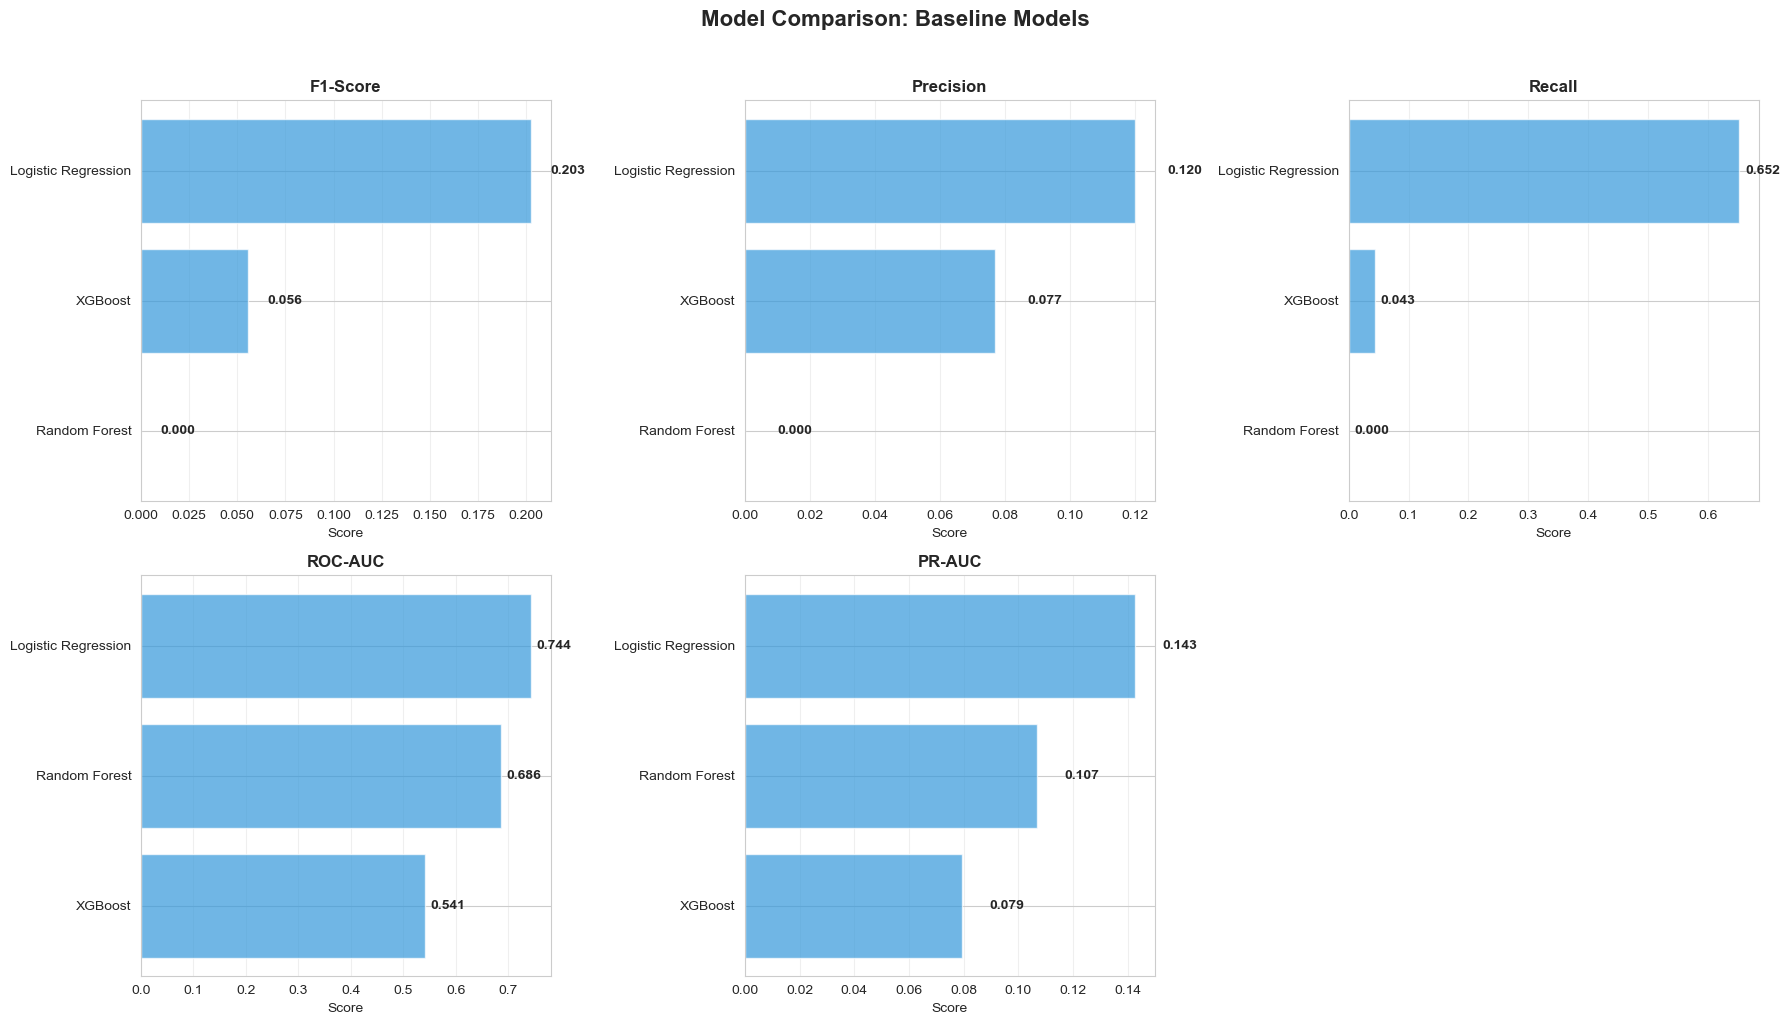


🏆 Best Model (by F1-Score): Logistic Regression
   F1-Score: 0.2027


In [11]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'F1-Score': [results['f1'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'ROC-AUC': [results['roc_auc'] for results in model_results.values()],
    'PR-AUC': [results['pr_auc'] for results in model_results.values()]
}).sort_values('F1-Score', ascending=False)

print("Model Comparison (Validation Set):")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    comparison_df_sorted = comparison_df.sort_values(metric, ascending=True)
    ax.barh(comparison_df_sorted['Model'], comparison_df_sorted[metric], color='#3498db', alpha=0.7)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Score')
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(comparison_df_sorted[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Model Comparison: Baseline Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Best Model (by F1-Score): {best_model_name}")
print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")


---

## Section 5: Hyperparameter Tuning with K-Fold CV (Logistic Regression)

Use Stratified K-Fold cross-validation on the **training set** to tune Logistic Regression hyperparameters, then evaluate the best model on the **validation** and **test** sets.


### 5.1 Logistic Regression Pipeline & Grid Search

We'll create a **Pipeline** that:
- Applies `StandardScaler` to numeric features
- Applies `OneHotEncoder` to categorical features (e.g., `position`)
- Fits a `LogisticRegression` classifier with `class_weight='balanced'`

Then we'll run **GridSearchCV** with **StratifiedKFold (5-fold)** on the **training set** to tune the regularization strength `C` using **F1-score** as the scoring metric.


In [12]:
# Build preprocessing + Logistic Regression pipeline

numeric_features = numeric_cols
categorical_features = categorical_cols

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

log_reg = LogisticRegression(
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

# Hyperparameter grid for C (regularization strength)
param_grid = {
    'classifier__C': np.logspace(-3, 2, 6)  # [0.001, 0.01, 0.1, 1, 10, 100]
}

print("Running GridSearchCV with StratifiedKFold (5-fold) using F1-score...")

grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")

best_lr_pipeline = grid_search.best_estimator_

# Evaluate tuned model on validation and test sets
lr_tuned_val_results = evaluate_model(best_lr_pipeline, X_val, y_val,
                                      "Logistic Regression (Tuned)", "Validation")

lr_tuned_test_results = evaluate_model(best_lr_pipeline, X_test, y_test,
                                       "Logistic Regression (Tuned)", "Test")


Running GridSearchCV with StratifiedKFold (5-fold) using F1-score...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best Parameters:
{'classifier__C': np.float64(0.01)}
Best CV F1-score: 0.2274

Logistic Regression (Tuned) - Validation Set Performance
F1-Score:        0.2112
Precision:       0.1232
Recall:          0.7391
ROC-AUC:         0.7477
PR-AUC:          0.1592

Confusion Matrix:
[[243 121]
 [  6  17]]

Classification Report:
               precision    recall  f1-score   support

Not Called Up       0.98      0.67      0.79       364
    Called Up       0.12      0.74      0.21        23

     accuracy                           0.67       387
    macro avg       0.55      0.70      0.50       387
 weighted avg       0.93      0.67      0.76       387


Logistic Regression (Tuned) - Test Set Performance
F1-Score:        0.1358
Precision:       0.0791
Recall:          0.4783
ROC-AUC:         0.6714
PR-AUC:          0.0866

Confusion Matrix:
[[236 128]
 [ 12  11]]



### 5.2 ROC and Precision-Recall Curves (Test Set)

Visualize the tuned Logistic Regression model's performance on the held-out **test set** using ROC and Precision-Recall curves.


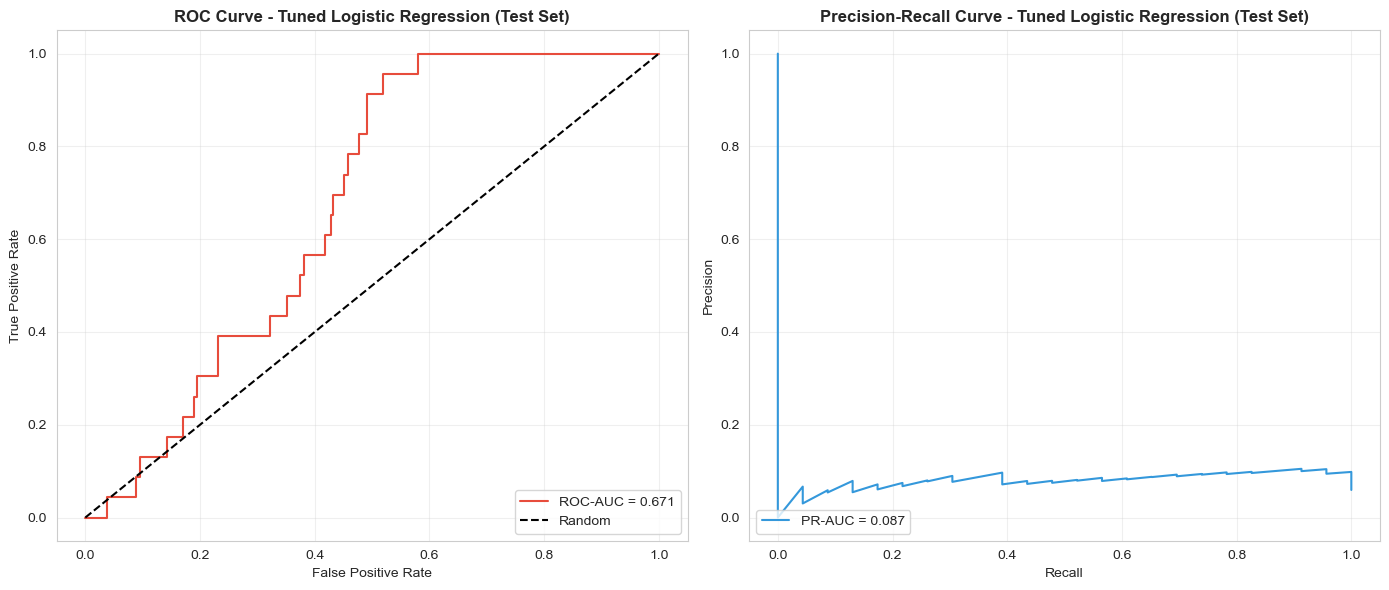

In [13]:
# ROC and Precision-Recall curves for tuned Logistic Regression on test set

from sklearn.metrics import roc_curve, precision_recall_curve

y_test_proba = lr_tuned_test_results['y_pred_proba']

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
axes[0].plot(fpr, tpr, label=f"ROC-AUC = {lr_tuned_test_results['roc_auc']:.3f}", color='#e74c3c')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_title('ROC Curve - Tuned Logistic Regression (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall, precision, label=f"PR-AUC = {lr_tuned_test_results['pr_auc']:.3f}", color='#3498db')
axes[1].set_title('Precision-Recall Curve - Tuned Logistic Regression (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 5.3 Saving Tuned Model for Streamlit

Save the tuned Logistic Regression pipeline so the Streamlit app can load it and generate call-up probability predictions for any player.


In [14]:
# Save tuned Logistic Regression pipeline for use in Streamlit app
import os

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

model_path = os.path.join(models_dir, 'log_reg_callup_pipeline.joblib')
joblib.dump(best_lr_pipeline, model_path)

print(f"✅ Tuned Logistic Regression pipeline saved to: {model_path}")
print("The Streamlit app can load this model and use predict_proba() to show call-up probabilities for selected players.")


✅ Tuned Logistic Regression pipeline saved to: models/log_reg_callup_pipeline.joblib
The Streamlit app can load this model and use predict_proba() to show call-up probabilities for selected players.
